In [ ]:
!pip install -q autoawq
!pip install -q vllm

# Load model

We will use quantized model (AWQ) to fit model in free Colab tier. vLLM will speed up inference.

In [ ]:
from vllm import LLM, SamplingParams
import torch
import numpy as np

llm = LLM(model="TheBloke/Mistral-7B-Instruct-v0.2-AWQ",
          quantization='awq',
          dtype='half',
          max_model_len=128)


In [ ]:
sampling_params = SamplingParams(temperature=0,
                                 max_tokens=8)

prompts = [
    "[INST] Return only result witn no explanation: 2 + 2[/INST] = ",
    "[INST] Return only result witn no explanation: 234 * 231 [/INST] = ",
]

outputs = llm.generate(prompts, sampling_params)

# Print the outputs.
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"\nPrompt: {prompt!r}, \nGenerated text: {generated_text!r}")

#Prepare data

In [11]:
def clean_output(txt):
  x = txt.strip().split()[0].replace(',', '')
  try:
    x = float(x)
    return x
  except ValueError:
    return

In [12]:
PROMPT = "[INST] Return only result witn no explanation: {inst} [/INST] = "

def calculate(dataset, operation):
  p = [PROMPT.format(inst=f'{a} {operation} {b}') for a, b, _ in dataset]
  outputs = llm.generate(p, sampling_params)
  return [x.outputs[0].text for x in outputs]

### Generate dataset

In [13]:
def add(a, b):
    return a + b


def subtract(a, b):
    return a - b


def multiply(a, b):
    return a * b


def divide(a, b):
    if b != 0:
        return round(a / b, 2)
    else:
        return None  # Handle division by zero


def generate_dataset(start, end, function):
     return [(i, j, function(i, j)) for i in range(start, end + 1) for j in range(start, end + 1)]

### Plot results

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(dataset, weights, operator='+'):
  a_values, b_values, _ = zip(*dataset)

  # Creating bins for a and b with bin size 10
  a_bins = np.arange(1, 110, 10)
  b_bins = np.arange(1, 110, 10)

  # Creating a 2D histogram based on the sum of 'True' values
  heatmap, xedges, yedges = np.histogram2d(a_values,
                                           b_values,
                                           bins=[a_bins, b_bins],
                                           weights=weights)

  # Plotting the heatmap
  plt.imshow(heatmap,
             extent=[xedges[0],
                     xedges[-1],
                     yedges[0],
                     yedges[-1]],
             origin='lower',
             cmap='viridis',
             aspect='auto')
  plt.colorbar(label='Number of correct values')
  plt.xlabel('a')
  plt.ylabel('b')
  plt.title(f'Number of Correct Answers for a {operator} b')

  plt.show()

## Test adding

In [7]:
add_dataset = generate_dataset(1, 100, add)
results_raw = calculate(add_dataset, '+')
results = [clean_output(x) for x in results_raw]

Processed prompts: 100%|██████████| 10000/10000 [04:51<00:00, 34.33it/s]


In [8]:
y_true = [x[2] for x in add_dataset]
y_true = np.array(y_true)
results = np.array(results)
acc = sum(results == y_true) / len(results)

In [9]:
acc

0.9677

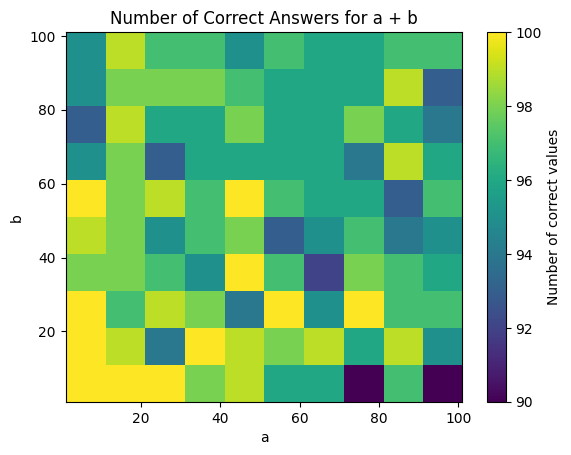

In [11]:
plot_heatmap(add_dataset, results==y_true)

## Test multiplication

In [12]:
mul_dataset = generate_dataset(1, 100, multiply)
results_raw = calculate(mul_dataset, '*')
results = [clean_output(x) for x in results_raw]

Processed prompts: 100%|██████████| 10000/10000 [05:54<00:00, 28.19it/s]


In [13]:
y_true = [x[2] for x in mul_dataset]
y_true = np.array(y_true)
results = np.array(results)
acc = sum(results == y_true) / len(results)

In [14]:
acc

0.3854

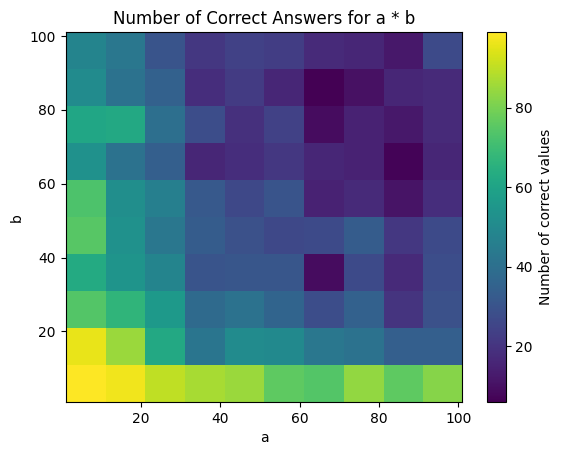

In [15]:
plot_heatmap(mul_dataset, results==y_true, operator='*')

# Test fine-tuned model

### Finetune dataset

Multiplication for  a, b in range 60-100.

In [9]:
from vllm import LLM, SamplingParams
import torch
import numpy as np

llm = LLM(model="adriata/calc_mistral_awq",
          quantization='awq',
          dtype='half',
          max_model_len=128)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/821 [00:00<?, ?B/s]

WARNING 03-14 20:01:11 config.py:193] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 03-14 20:01:11 llm_engine.py:87] Initializing an LLM engine with config: model='adriata/calc_mistral_awq', tokenizer='adriata/calc_mistral_awq', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=128, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=awq, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

INFO 03-14 20:01:21 weight_utils.py:163] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/4.15G [00:00<?, ?B/s]

INFO 03-14 20:04:51 llm_engine.py:357] # GPU blocks: 4159, # CPU blocks: 2048
INFO 03-14 20:04:54 model_runner.py:684] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 03-14 20:04:54 model_runner.py:688] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 03-14 20:05:08 model_runner.py:756] Graph capturing finished in 14 secs.


In [16]:
sampling_params = SamplingParams(temperature=0,
                                 max_tokens=8)

In [17]:
mul_dataset = generate_dataset(1, 100, multiply)
results_raw = calculate(mul_dataset, '*')
results = [clean_output(x) for x in results_raw]

Processed prompts: 100%|██████████| 10000/10000 [06:16<00:00, 26.56it/s]


In [18]:
y_true = [x[2] for x in mul_dataset]
y_true = np.array(y_true)
results = np.array(results)
acc = sum(results == y_true) / len(results)
acc

0.6436

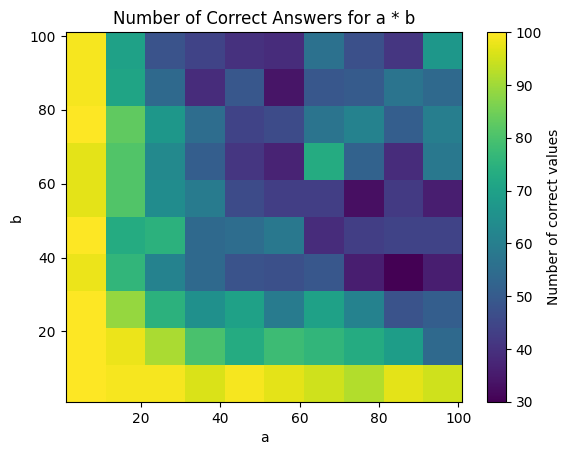

In [19]:
plot_heatmap(mul_dataset, results==y_true, operator='*')